# Land ice Investigations

Let's start by importing modules

In [1]:
# Homemade models
from modules import week8 as w8
from modules import week5 as w5
from modules import week9 as w9
from modules import week10 as w10
from modules import misc

# Calculations and data stuff
import numpy as np
import xarray as xr
from pyproj import Proj, transform

# plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs

%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
table {float:left}
</style>

Now we want to check we have the right data. 
## Data we want
The statuses go as follows:

    Not downloaded -> Downloaded -> Processed -> Loaded

| Variable        	| Source 	| Status     	|
|-----------------	|--------	|------------	|
| Land Ice        	| GRACE  	| Loaded     	|
| Ice Velocity    	| NSIDC  	| Downloaded 	|
| LW radiation    	| ERA5   	| Loaded     	|
| SW radiation    	| ERA5   	| Loaded     	|
| Cloud Variables 	| ERA5   	| Loaded     	|
| Temperature     	| ERA5   	| Loaded     	|
| Ozone           	| ERA5   	| Loaded     	|

Some of the variables need reprojecting, specifically the ones from the ERA5 dataset. let's do that here.

In [3]:
# # Cloud Cover
# clouds = xr.open_dataset('data/ERA5/clouds.nc')
# cc = clouds.cc.sel(level=700).sel(expver=1)
# w10.process_data(cc, variable = 'cc_700')
# cc = clouds.cc.sel(level=500).sel(expver=1)
# w10.process_data(cc, variable = 'cc_500')
# cc = clouds.cc.sel(level=200).sel(expver=1)
# w10.process_data(cc, variable = 'cc_200')

# # # Ozone
# ozone = xr.open_dataset('data/ERA5/ozone_mass_mixing_ratio.nc')
# o3 = ozone.o3.sel(level=700).sel(expver=1)
# w10.process_data(o3, variable = 'o3_700')
# o3 = ozone.o3.sel(level=500).sel(expver=1)
# w10.process_data(o3, variable = 'o3_500')
# o3 = ozone.o3.sel(level=200).sel(expver=1)
# w10.process_data(o3, variable = 'o3_200')


# # Radiation
# surface_net_solar_radiation = xr.open_dataset('data/ERA5/surface_net_solar_radiation.nc')
# surface_solar_radiation_downwards = xr.open_dataset('data/ERA5/surface_solar_radiation_downwards.nc')
# ssr = surface_net_solar_radiation.ssr.sel(expver=1)
# ssrd = surface_solar_radiation_downwards.ssrd.sel(expver=1)
# ssru = ssr-ssrd
# w10.process_data(ssr, variable = 'ssr')
# w10.process_data(ssr, variable = 'ssrd')
# w10.process_data(ssr, variable = 'ssru')

In [4]:
# Loading data from file
SIC, LIC = w8.load_ice_data()
SIC = SIC.sel(time=slice('1979-01-01','2019-12-31')).compute()
LIC = LIC.sel(time=slice('1979-01-01','2019-12-31')).compute()
temperature = w8.load_temp_data().sel(time=slice('1979-01-01','2019-12-31')).compute()

# Landmask
landmask = w8.load_landmask()
landmask = landmask >= .5

# New variables
cc_700 = xr.open_dataarray('processed_data/cc_700.nc')
cc_500 = xr.open_dataarray('processed_data/cc_500.nc')
cc_200 = xr.open_dataarray('processed_data/cc_200.nc')
o3_700 = xr.open_dataarray('processed_data/o3_700.nc')
o3_500 = xr.open_dataarray('processed_data/o3_500.nc')
o3_200 = xr.open_dataarray('processed_data/o3_200.nc')
ssrd = xr.open_dataarray('processed_data/ssrd.nc')
ssru = xr.open_dataarray('processed_data/ssru.nc')
ssr = xr.open_dataarray('processed_data/ssr.nc')

data = xr.Dataset()
data['SIC'] = SIC
data['LIC'] = LIC
data['landmask'] = landmask
data['cc_700'] = cc_700
data['cc_500'] = cc_500
data['cc_200'] = cc_200
data['o3_700'] = o3_700
data['o3_500'] = o3_500
data['o3_200'] = o3_200
data['ssrd'] = ssrd
data['ssru'] = ssru
data['ssr'] = ssr
data['skt'] = temperature.skt

data['LIC'] = data.LIC.where(landmask)

attrs = {v:data[v].attrs for v in data}

misc.print_heading("Data Loaded")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:04<00:00, 45.45it/s]


------------------------------------------------------------------------------
                                 Data Loaded                                 
------------------------------------------------------------------------------


In [6]:
data_annually_averaged = (data.pipe(w5.yearly_average)).copy()
data_anomalous = (data.pipe(w5.find_anomalies).pipe(w5.yearly_average)).copy()
data_short = data_anomalous.sel(time=slice('2002-01-01', '2019-12-31')).copy()
data_long = data_anomalous.sel(time=slice('1979-01-01', '2019-12-31')).copy()

for variable, attributes in attrs.items():
    data[variable].attrs = attributes
    data_anomalous[variable].attrs = attributes
    data_short[variable].attrs = attributes
    data_long[variable].attrs = attributes

misc.print_heading("Preprocessing Done")
data_short

------------------------------------------------------------------------------
                             Preprocessing Done                              
------------------------------------------------------------------------------


<xarray.Dataset>
Dimensions:   (time: 18, x: 316, y: 332)
Coordinates:
  * time      (time) datetime64[ns] 2002-01-01 2003-01-01 ... 2019-01-01
  * y         (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x         (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    SIC       (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    LIC       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    landmask  (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cc_700    (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cc_500    (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cc_200    (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    o3_700    (time, y, x) float64 0.0 0.0 0.0 ... 8.851e-09 8.846e-09 8.831e-09
    o3_500    (time, y, x) float64 0.0 0.0 0.0 ... 1.219e-08 1.228e-08 1.238e-08
    o3_200    (time, y, x) float64 0.0 0.0 0.0 ... 8.843e-09 8.243e-09 7.688e-09
    ssrd      (time, y, x) float64 0.0 0.0 0.0 ... -9.367e+04 -7.588e+04
    ssru      (time, y, x) float64 0.0 0.0 0.0 ... -9.367e+04 -7.588e+04
    ssr       (time, y, x) float64 0.0 0.0 0.0 ... -9.367e+04 -7.588e+04
    skt       (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.4128 -0.427 -0.4652

Now we want to plot the distribution for the different variables individually and together

In [7]:
def plot_mean_spatial_distribution(data, name):
    data_mean = data.mean(dim='time')
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
    contour = plt.contourf(data_mean.x, data_mean.y, data_mean.values, transform = ccrs.SouthPolarStereo())
    ax.coastlines()
    ax.set_title(f'Mean {name} from 1979 to 2019')
    fig.subplots_adjust(right=0.95)
    cbar_ax = fig.add_axes([0.93, 0.2, 0.05, 0.6])
    cbar = fig.colorbar(contour, cax=cbar_ax, shrink=0.88)
    if data.attrs != {}:
        cbar.ax.set_ylabel(f'{data.attrs["long_name"]} [{data.attrs["units"]}]')
    misc.savefigures(folder=f'images/2021w2',
                     filename=f'mean_spatial_{data.name}')
    plt.show()

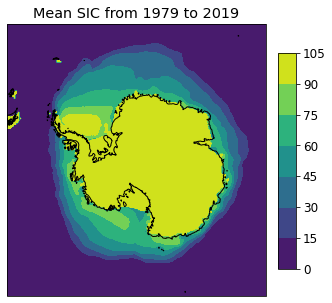

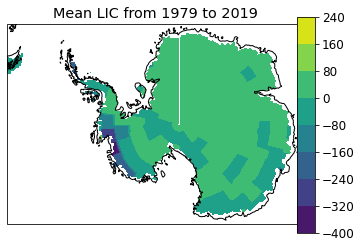

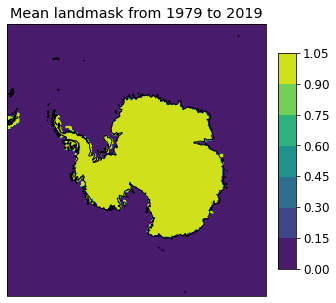

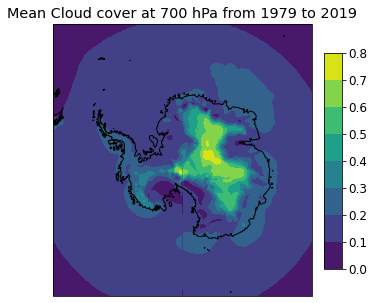

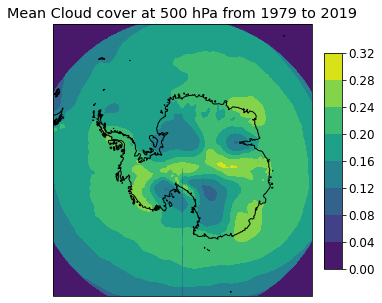

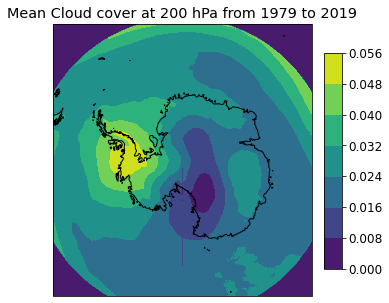

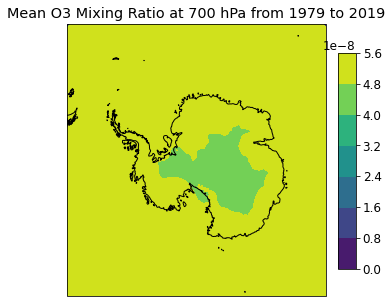

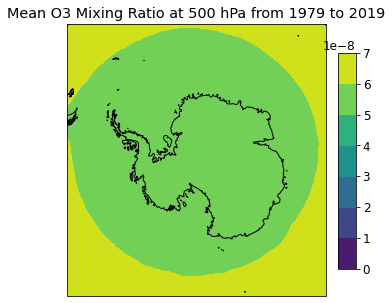

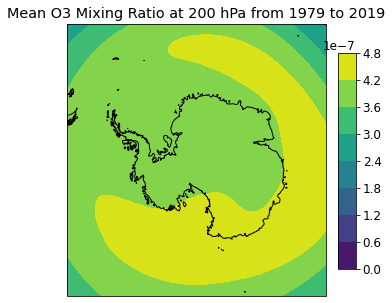

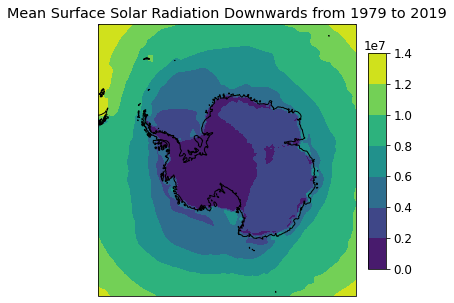

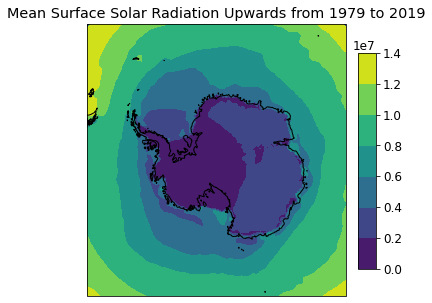

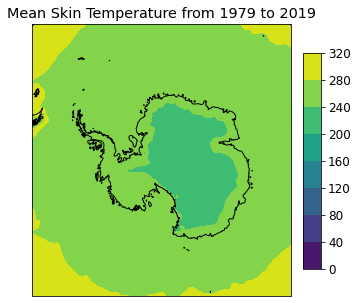

In [12]:
namedict = {'SIC'     : 'SIC',
            'LIC'     : 'LIC',
            'landmask': 'landmask',
            'cc_700'  : 'Cloud cover at 700 hPa',
            'cc_500'  : 'Cloud cover at 500 hPa',
            'cc_200'  : 'Cloud cover at 200 hPa',
            'o3_700'  : 'O3 Mixing Ratio at 700 hPa',
            'o3_500'  : 'O3 Mixing Ratio at 500 hPa',
            'o3_200'  : 'O3 Mixing Ratio at 200 hPa',
            'ssrd'    : 'Surface Solar Radiation Downwards',
            'ssru'    : 'Surface Solar Radiation Upwards',
            'skt'     : 'Skin Temperature'}
for variable, name in namedict.items():
    plot_mean_spatial_distribution(data_annually_averaged[variable], name)

# Correlations

Before doing any complex analysis let's calculate the correlation between each variable and the land ice for each gridpoint.

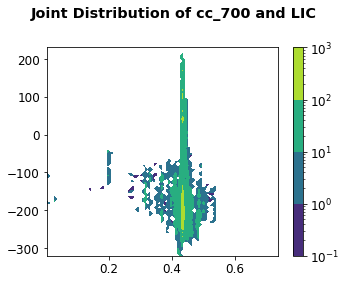

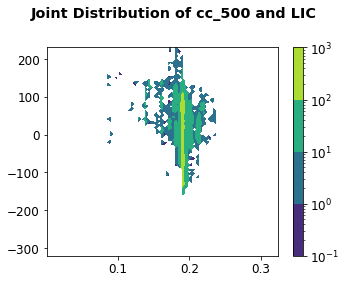

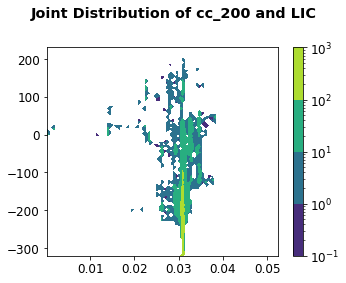

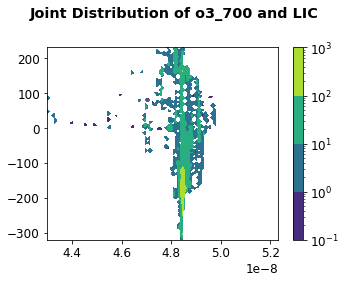

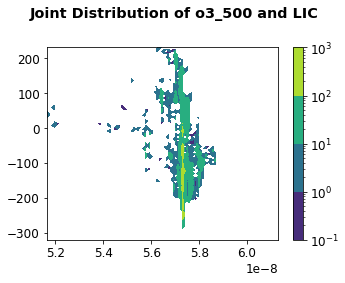

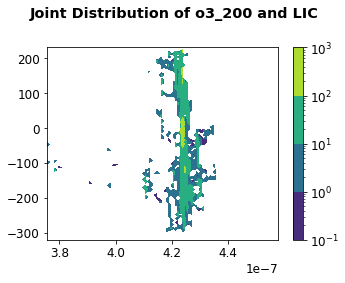

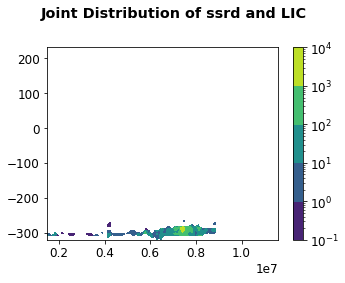

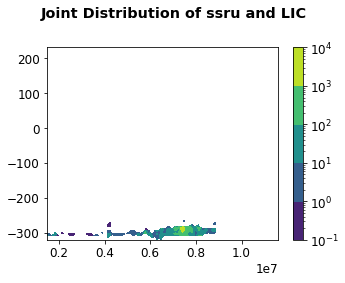

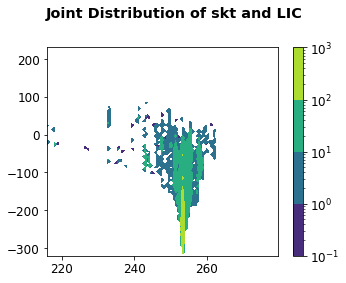

In [13]:
variables = ['cc_700','cc_500','cc_200','o3_700','o3_500','o3_200','ssrd','ssru','skt']
for variable in variables:
    w10.plot_scatter(data_annually_averaged.copy(), independent=variable, dependant='LIC', landmask=True, filename = f'LIC_and_{variable}')
#     w10.plot_scatter(data_anomalous.copy(), independent=variable, dependant='LIC', landmask=True, filename = f'LIC_and_{variable}_anomalous')

In [38]:
correlations_dict = {}
for variable in variables:
    subdata = data_annually_averaged.sel(time=slice('2002-01-01', '2019-12-31'))
    correlations_dict[variable] = xr.corr(subdata['LIC'],subdata[variable], dim='time')
correlations_dict

{'cc_700': <xarray.DataArray (y: 332, x: 316)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])
 Coordinates:
   * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
   * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000,
 'cc_500': <xarray.DataArray (y: 332, x: 316)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])
 Coordinates:
   * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
   * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3

In [39]:
regression_dict['cc_700']

<xarray.Dataset>
Dimensions:            (time: 18, x: 316, y: 332)
Coordinates:
  * time               (time) datetime64[ns] 2002-01-01 ... 2019-01-01
  * y                  (y) int32 4350000 4325000 4300000 ... -3900000 -3925000
  * x                  (x) int32 -3950000 -3925000 -3900000 ... 3900000 3925000
Data variables:
    LIC                (x, y, time) float64 nan nan nan nan ... nan nan nan nan
    cc_700             (x, y, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    prediction_cc_700  (x, y, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    regr_coef_cc_700   (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    regr_coef_error    (x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

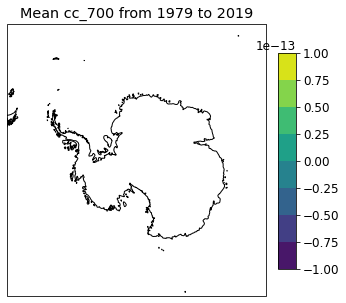

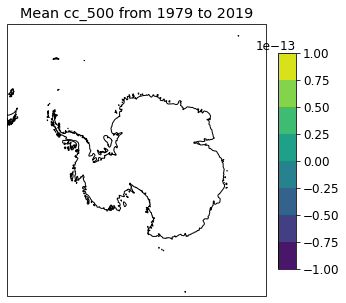

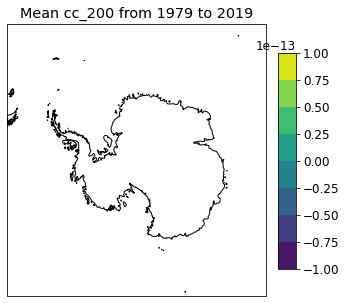

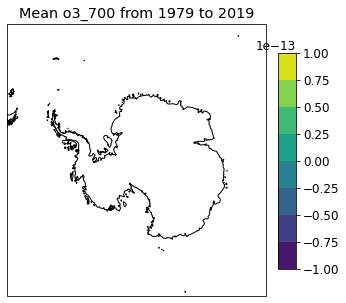

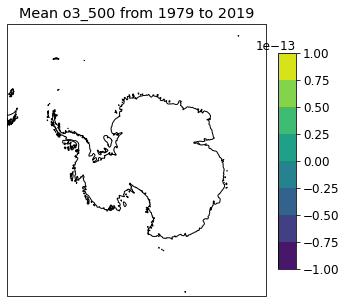

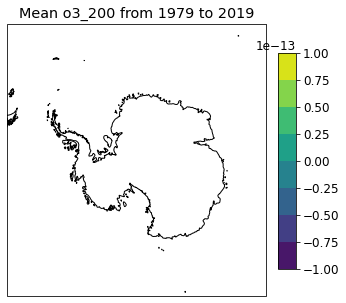

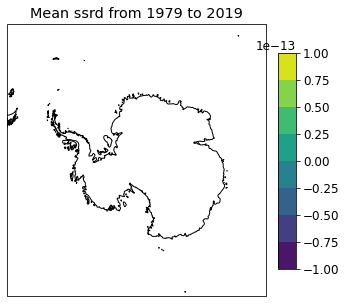

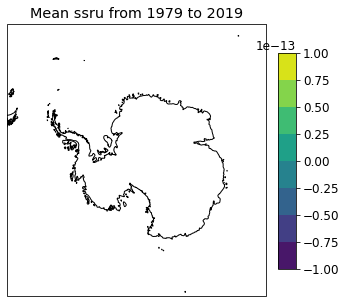

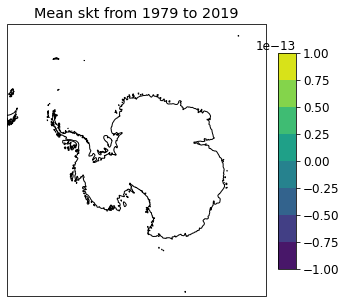

In [40]:
for variable in variables:
    data_spatial = correlations_dict[variable]
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
    contour = plt.contourf(data_spatial.x, data_spatial.y, data_spatial.values, transform = ccrs.SouthPolarStereo())
    ax.coastlines()
    ax.set_title(f'Mean {variable} from 1979 to 2019')
    fig.subplots_adjust(right=0.95)
    cbar_ax = fig.add_axes([0.93, 0.2, 0.05, 0.6])
    cbar = fig.colorbar(contour, cax=cbar_ax, shrink=0.88)